# Data Exploration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the riz training data:

In [4]:
from tomo_challenge import load_data, load_redshift

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [2]:
bands='riz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 8615613 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [48]:
def prepare(band='i', n=100000, seed=123):
    n = n or len(train_data)
    colors = np.diff(train_data, axis=1)
    i = bands.index(band)
    gen = np.random.RandomState(seed)
    idx = gen.choice(len(train_data), n, replace=False)
    return np.concatenate((colors[idx], train_data[idx, i:i + 1]), axis=1), train_z[idx]

In [62]:
X, y = prepare(n=1000000)

In [94]:
def plot(features, redshift, npct=10, nhist=100, inset_pct=1, show_edges=True):
    ndata, nfeat = features.shape
    assert redshift.shape == (ndata,)
    D = np.concatenate((features, redshift.reshape(-1, 1)), axis=1).T
    
    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    edges = np.percentile(D, pct, axis=1).T

    # Calculate inset ranges for histograms.
    ranges = np.percentile(D, (inset_pct, 100 - inset_pct), axis=1).T
    
    fig, axes = plt.subplots(nfeat + 1, nfeat + 1, figsize=(12, 12))
    for i in range(nfeat + 1):
        ax = axes[i, i]
        ax.hist(D[i], nhist, range=ranges[i])
        ax.set_xlim(*ranges[i])
        ax.set_yticks([])
        if show_edges:
            for edge in edges[i]:
                ax.axvline(edge, c='r', alpha=0.5, lw=1)
        for j in range(i + 1, nfeat + 1):
            ax = axes[j, i]
            hist, _, _ = np.histogram2d(D[i], D[j], [edges[i], edges[j]])
            ax.imshow(hist, origin='lower', interpolation='none', extent=[0, 100, 0, 100])
            ax = axes[i, j]
            ax.hist2d(D[j], D[i], nhist, range=(ranges[j], ranges[i]))
            if show_edges:
                for edge in edges[j]:
                    ax.axvline(edge, c='r', alpha=0.5, lw=1)
                for edge in edges[i]:
                    ax.axhline(edge, c='r', alpha=0.5, lw=1)

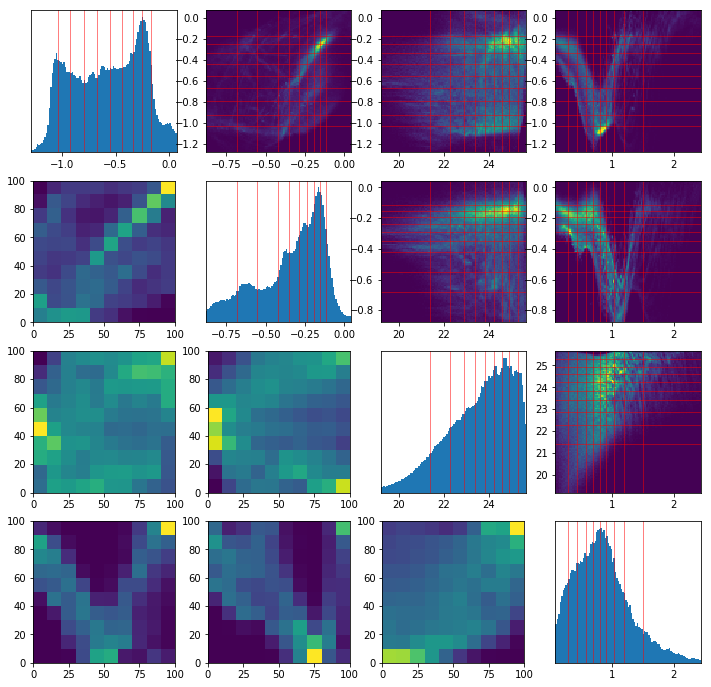

In [95]:
plot(X, y)